## Group Members: Martina Serandrei, Giulia Macis, Francesco Capo
We are a team of a marketing corporation, specialized in machine learning, we have been assigned the job to segment the customers of a big Brazilian subsidiary, so that our colleagues can develop an appropriate target email campaign.
Starting from the dataset we were provided with, we will divide the customers according to the RFM strategy.

In [234]:
#import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch

from numpy import where, unique
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from IPython.display import display

In [235]:
# Importing the dataset
csdv_df = pd.read_csv('customer_segmentation.csv')

### EDA
Since the dataset contains much information about the customers, it is required to deeply analyze the data before starting to work on it. Below we check some features of our dataset to find if there are any variables that can be ignored because they might be useful for our analysis, and afterwards we check its shape, and we compute some useful descriptive statistics.

In [236]:
csdv_df.head() #first 5 entries of the dataset to understand the data we are dealing with

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type,payment_installments,...,seller_id,shipping_limit_date,price,freight_value,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_category_name_english
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.7,22.76,belo horizonte,SP,perfumaria,29,178,perfumery
1,86674ccaee19790309333210917b2c7d,1b338293f35549b5e480b9a3d7bbf3cd,delivered,2018-08-09 11:37:35,2018-08-09 14:35:19,2018-08-10 14:34:00,2018-08-14 18:51:47,2018-08-22 00:00:00,credit_card,5,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-13 14:31:29,116.9,18.92,belo horizonte,SP,perfumaria,29,178,perfumery
2,aee682982e18eb4714ce9f97b15af5e2,8858442ea4d5dc5bb9e118e8f728095d,delivered,2018-07-09 18:46:28,2018-07-11 03:45:45,2018-07-11 15:01:00,2018-07-12 18:14:35,2018-07-18 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-13 03:45:45,118.7,9.34,belo horizonte,SP,perfumaria,29,178,perfumery
3,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery
4,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery


In [237]:
print("Dataset shape:")
 #number of rows and columns of our dataset
print(csdv_df.shape)

Dataset shape:
(13801, 26)


In [238]:
csdv_df.describe() #compute some useful descriptive statistics which summarize the central tendency, dispersion, and shape of a dataset’s distribution, excluding NaN values

,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght
count,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000
mean,3.014637,194.349691,1.230491,130.947103,21.938168,49.300703,814.330411
std,2.801721,294.854258,0.737495,210.712421,18.567013,9.759529,648.790194
min,1.000000,0.050000,1.000000,0.850000,0.000000,8.000000,4.000000
25%,1.000000,66.750000,1.000000,40.000000,12.870000,43.000000,366.000000
50%,2.000000,120.290000,1.000000,79.000000,18.230000,52.000000,631.000000
75%,4.000000,206.780000,1.000000,139.000000,23.310000,57.000000,1030.000000
max,20.000000,7274.880000,13.000000,4590.000000,375.280000,69.000000,3985.000000


Looking at the data we decided to discard some variables:
 product_category_name, product_name_length e product_description_length, due to the fact that they are not relevant to our analysis.

In [239]:
csdv_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_type', 'payment_installments', 'payment_value',
       'customer_unique_id', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'seller_city', 'seller_state',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_category_name_english'],
      dtype='object')

In [240]:
csdv_df_new = csdv_df[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_type', 'payment_installments', 'payment_value',
       'customer_unique_id', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'seller_city', 'seller_state', 'product_category_name_english']] #the dataset we will use for our analysis

In [241]:
print('Unique variables in customer_unique_id:')
csdv_df_new['customer_unique_id'].nunique()

Unique variables in customer_unique_id:


11247

In [242]:

print('Unique variables in customer_id:')
csdv_df_new['customer_id'].nunique()

Unique variables in customer_id:


11394

Since we were uncertain whether using customer_id or customer_unique_id we counted the number of distinct elements of the 2 variables.
We notice that customer_id has more unique values than customer_unique_id. After some reasoning we decided that it was best to use customer_unique_id since it has less unique values implying that more orders are made by the same customer, this will help us in the future analysis.

In [243]:
# null values
csdv_df_new.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_type                     0
payment_installments             0
payment_value                    0
customer_unique_id               0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
seller_city                      0
seller_state                     0
product_category_name_english    0
dtype: int64

There are no null values in the dataset

In this part we first check if there are any rows that appear more than once, duplicate rows, and we proceed to remove them.

In [244]:
csdv_df_new.duplicated().sum()

83

In [245]:
csdv_df_new.drop_duplicates(keep='first', inplace=True)
csdv_df_new.reset_index(drop=True, inplace=True)

/var/folders/xr/fxzmlkxj7hj_7ywm0m_3sf8w0000gn/T/ipykernel_29189/24655691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csdv_df_new.drop_duplicates(keep='first', inplace=True)


To analyze the variables we work one we visualize the correlation among the numeric variables, we do so by using the built-in function seaborn heatmap.

<AxesSubplot:>

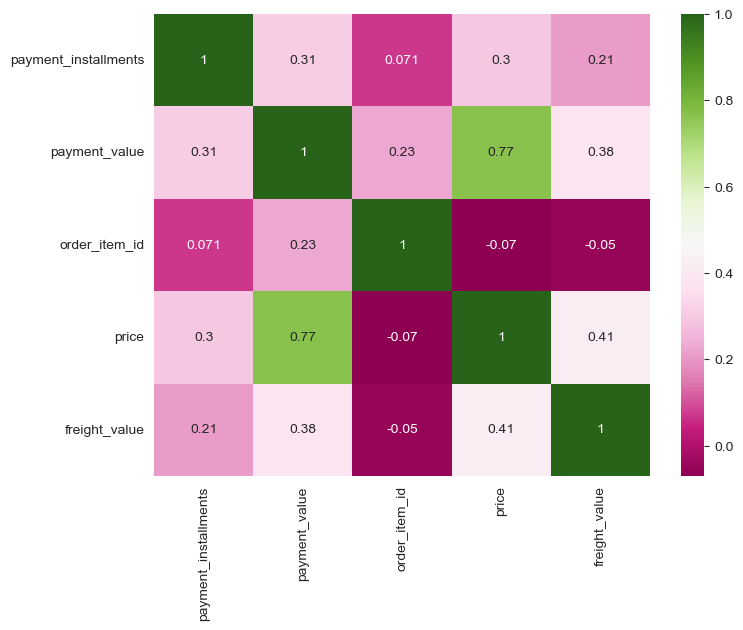

In [246]:
correlation = csdv_df_new.corr() #compute pairwise correlation of columns excluding NA/null values
table = plt.figure(figsize=(8,6))
sns.heatmap(correlation, annot=True, cmap="PiYG")

From the correlation map above we can see that there is a high correlation between payment_value and the price, while we have  a negative correlation, with order_item_id and the price since order_item_id stands for the number of items for each order, and the price means the price of each item. It is easily understandable from the description that the number of items that we place in an order cannot influence in any way the price of an item. We can make the same reasoning for order_item_id and freight_value.

Here we want to visualize some of the features which might be more influential for the customers' analysis. We start by plotting how many orders are carried out in each Brazilian federate state with a bar plot.

In [247]:
customer_state_counts = csdv_df_new.groupby('customer_state').size() #count the rows grouping by customer_state
customer_state_counts_df = pd.DataFrame([customer_state_counts]).T.reset_index() #transform the count obtained in a dataframe
customer_state_counts_df.columns = ['customer_state', 'Count']
customer_state_counts_df

,customer_state,Count
0,AC,5
1,AL,56
2,AM,24
3,AP,12
4,BA,532
5,CE,206
6,DF,297
7,ES,284
8,GO,272
9,MA,86


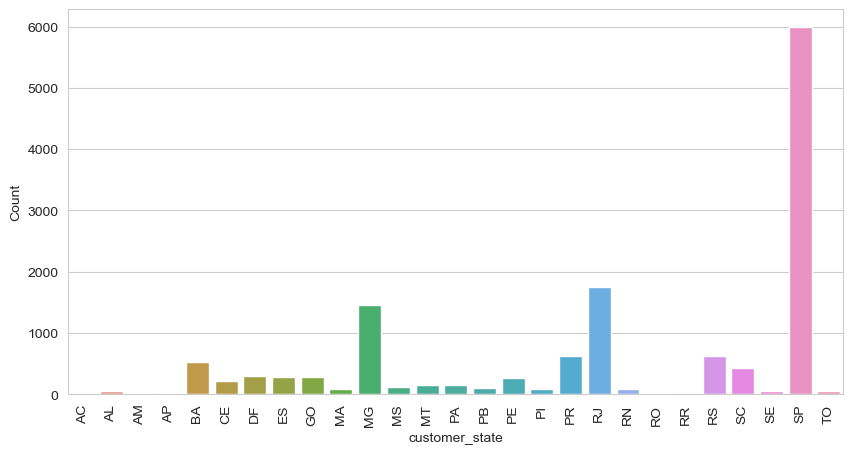

In [248]:
plt.figure(figsize=(10,5))
sns.barplot(x='customer_state', y='Count', data=customer_state_counts_df)
plt.xticks(rotation=90)
plt.show()

We can notice that the majority of the customers' purchases come from São Paulo state and this could be due to the fact that it is the most populated state.

Successively we wanted to visualize which payment types are used in each state, so we create a dataframe in which we store the payment types, for each of them we compute the number of times it has been used,and then we group by the state.

In [249]:
state_payment_df = csdv_df_new.groupby(['customer_state', 'payment_type']).count().reset_index() #count the rows grouping by customer_state and payment_type

state_payment_df = state_payment_df.drop(columns=['customer_id', 'order_status', 'order_purchase_timestamp','order_approved_at', 'order_delivered_carrier_date','order_delivered_customer_date', 'order_estimated_delivery_date', 'payment_installments', 'payment_value','customer_unique_id', 'customer_city', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'seller_city', 'seller_state', 'product_category_name_english']) #remove columns not interested in

state_payment_df.columns = ['customer_state', 'payment_type', 'count'] #rename columns
state_payment_df

,customer_state,payment_type,count
0,AC,boleto,1
1,AC,credit_card,4
2,AL,boleto,8
3,AL,credit_card,45
4,AL,debit_card,2
...,...,...,...
92,SP,voucher,202
93,TO,boleto,13
94,TO,credit_card,28
95,TO,debit_card,2


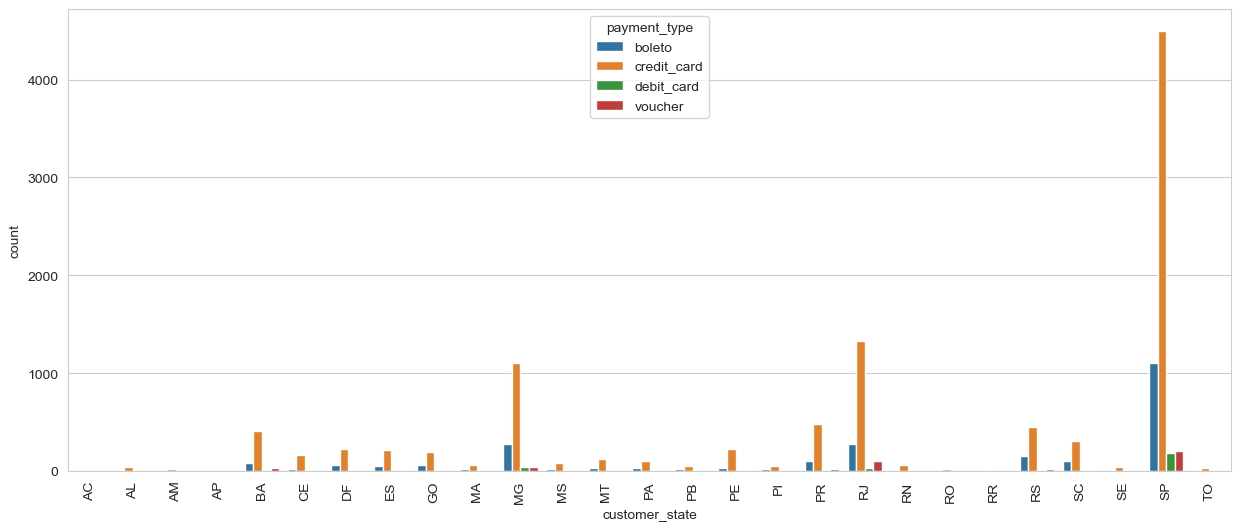

In [250]:
plt.figure(figsize=(15,6))
sns.barplot(x='customer_state', y='count', hue='payment_type', data=state_payment_df)
plt.xticks(rotation=90)
plt.show()

As we already deduced from the section above, the region where more payments have been made is San Paulo, here the most used payment type is credit card. More than 4000 orders where paid with this method, while with the boleto, the second most used payment type, we have only 1000 order. Overall the most used payment method in brazil is by credit card.

### OUTLIERS
We want to detect the outliers by visualizing the data with a pair plot and then decide if remove them or not.

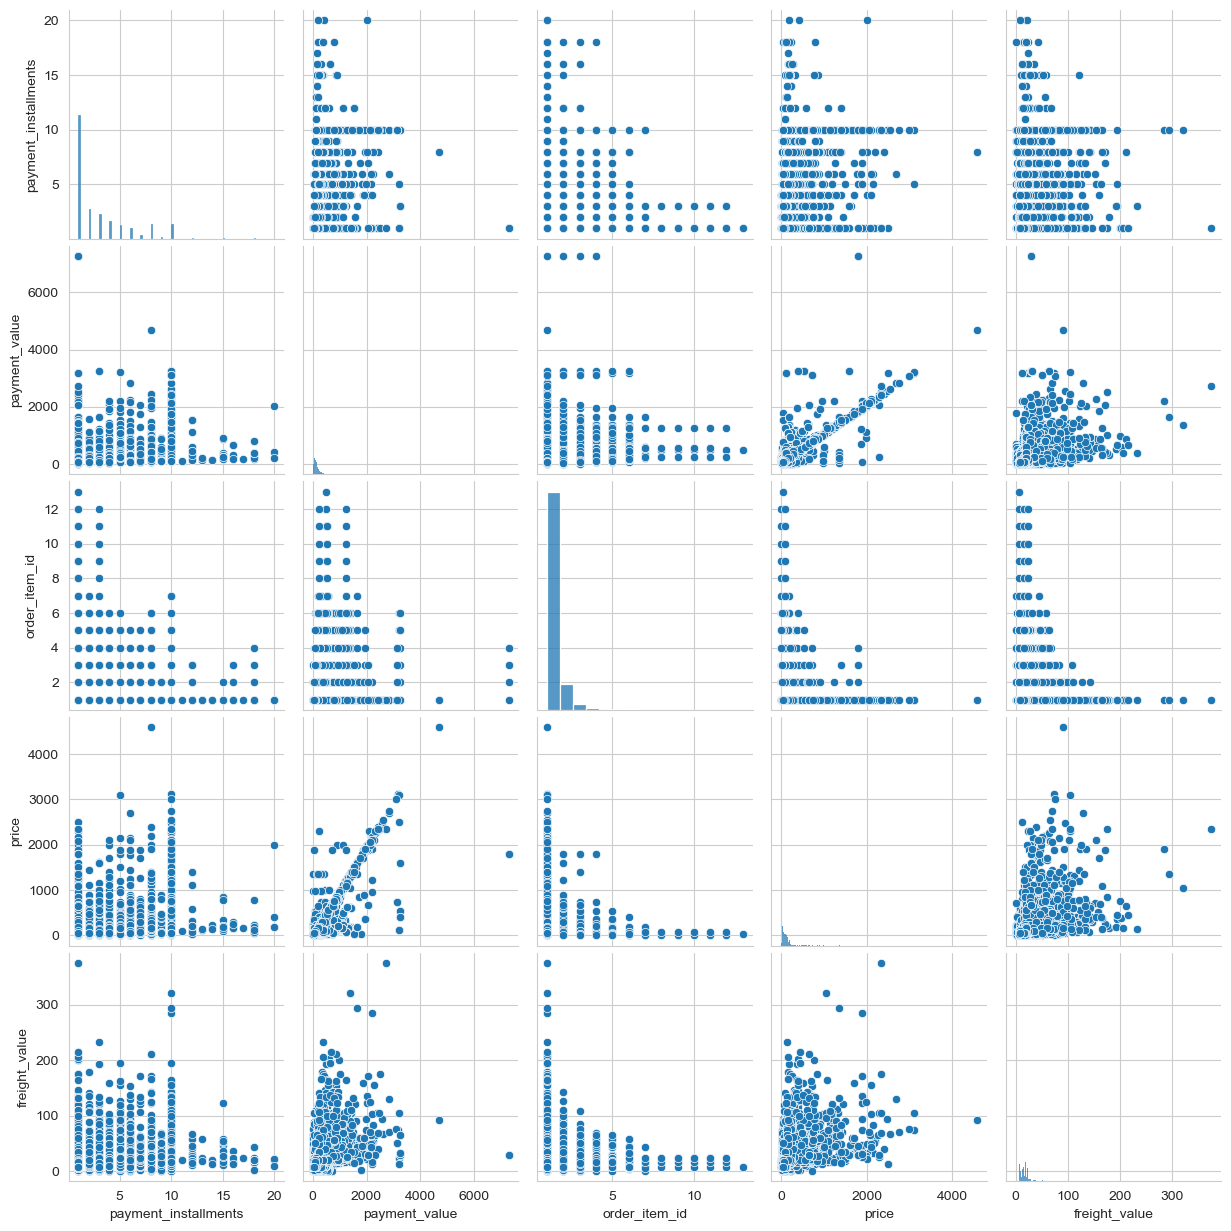

In [251]:
sns.pairplot(csdv_df_new)

In [252]:
'''outlier = csdv_df_new[csdv_df_new.payment_value > 4000] #remove values bigger than 4000
csdv_df_new = csdv_df_new.drop(outlier.index)
csdv_df_new = csdv_df_new.reset_index(drop=True)
csdv_df_new'''

'outlier = csdv_df_new[csdv_df_new.payment_value > 4000] #remove values bigger than 4000\ncsdv_df_new = csdv_df_new.drop(outlier.index)\ncsdv_df_new = csdv_df_new.reset_index(drop=True)\ncsdv_df_new'

We plot our numerical values in order to see if there are any outliers, after detecting them in payment_value and freight_value, we figured it was best to keep them, in order to have a broader view regarding the purchases.

Here we thought it would be interesting to analyze the number of orders that have been made each month,
therefore we firstly consider only the month of the dates of each purchase, and then we counted the number of orders.

In [253]:
#calculating the number of customers each month
customers=csdv_df_new[['order_purchase_timestamp', 'customer_unique_id']]
customers['month'] = pd.DatetimeIndex(customers['order_purchase_timestamp']).month #considering the month
customers = customers.groupby(['month']).count().reset_index()
customers = customers.drop(columns=['order_purchase_timestamp'])
customers.columns = ['month','count' ]
customers

/var/folders/xr/fxzmlkxj7hj_7ywm0m_3sf8w0000gn/T/ipykernel_29189/4293400603.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers['month'] = pd.DatetimeIndex(customers['order_purchase_timestamp']).month #considering the month


,month,count
0,1,6
1,2,22
2,3,125
3,4,2054
4,5,3188
5,6,2858
6,7,2758
7,8,2696
8,9,1
9,10,3


We also plotted the results in order to visualize them clearly

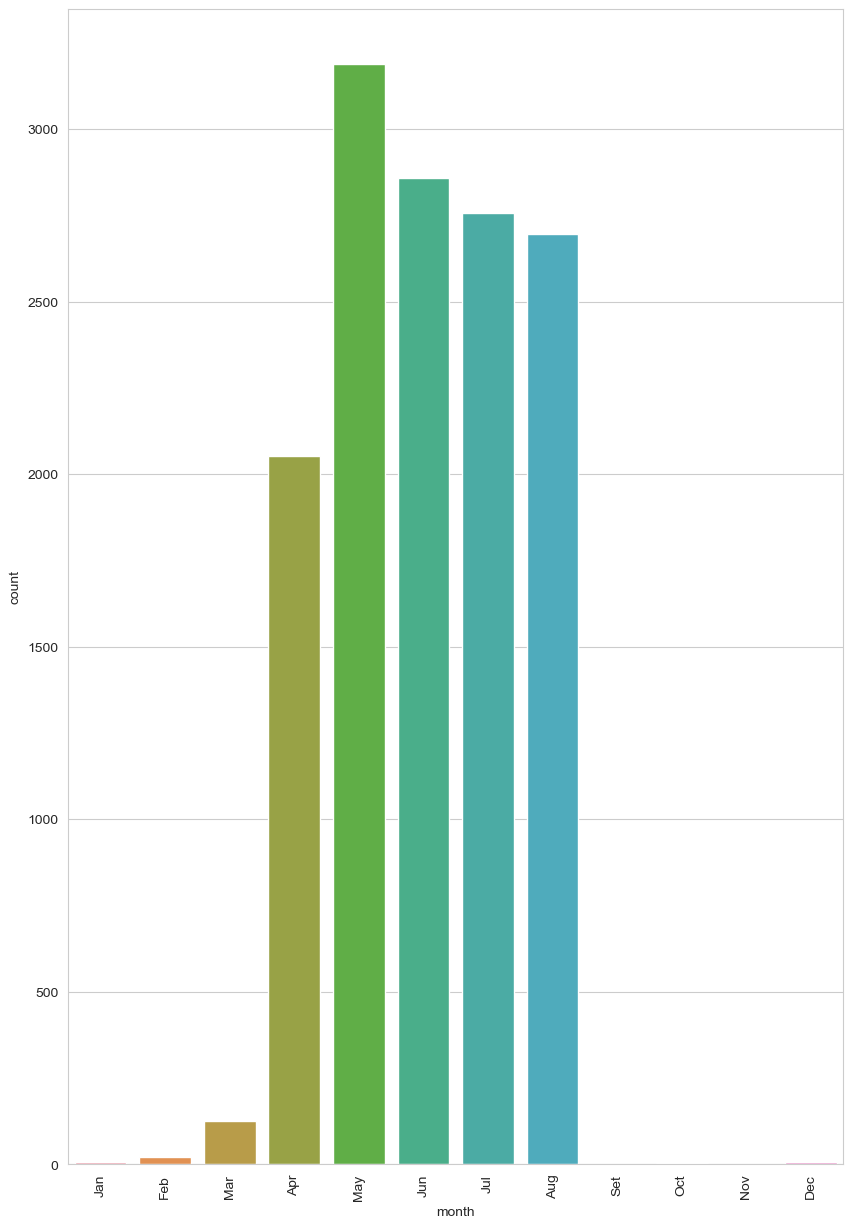

In [254]:
plt.figure(figsize=(10,15))
bar = sns.barplot(x='month', y='count',  data=customers)
plt.xticks(rotation=90)
ax1 = plt.subplot()
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Set', 'Oct', 'Nov', 'Dec'])
plt.show()

From the plot we clearly spot the big inconsistency among the purchases, as in the summer time orders have increased consistently.

### ONE HOT ENCODING
Since most machine learning algorithms cannot work with categorical data directly, it is required to convert the categorical variables into numbers, to do that we used One-hot encoding, which is a method to quantify categorical data.
In particular, we used the function get_dummies.

In [255]:
csdv_df_new = pd.get_dummies(csdv_df_new,
                             prefix=['customer_state:', 'payment_type:', 'seller_state:', 'product_category_name:'],
                             columns=['customer_state', 'payment_type', 'seller_state',
                                      'product_category_name_english'], drop_first=False)

csdv_df_new

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_installments,payment_value,...,product_category_name:_pet_shop,product_category_name:_signaling_and_security,product_category_name:_small_appliances,product_category_name:_small_appliances_home_oven_and_coffee,product_category_name:_sports_leisure,product_category_name:_stationery,product_category_name:_tablets_printing_image,product_category_name:_telephony,product_category_name:_toys,product_category_name:_watches_gifts
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,141.46,...,0,0,0,0,0,0,0,0,0,0
1,86674ccaee19790309333210917b2c7d,1b338293f35549b5e480b9a3d7bbf3cd,delivered,2018-08-09 11:37:35,2018-08-09 14:35:19,2018-08-10 14:34:00,2018-08-14 18:51:47,2018-08-22 00:00:00,5,135.82,...,0,0,0,0,0,0,0,0,0,0
2,aee682982e18eb4714ce9f97b15af5e2,8858442ea4d5dc5bb9e118e8f728095d,delivered,2018-07-09 18:46:28,2018-07-11 03:45:45,2018-07-11 15:01:00,2018-07-12 18:14:35,2018-07-18 00:00:00,1,128.04,...,0,0,0,0,0,0,0,0,0,0
3,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,2,279.30,...,0,0,0,0,0,0,0,0,0,0
4,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,2,279.30,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13713,493ba21a937e956c5e0e4e26c9f1b7f9,408d74d06be5d5140bb933f248de1342,delivered,2018-07-15 09:56:32,2018-07-16 13:30:36,2018-07-27 07:26:00,2018-08-02 18:06:41,2018-07-26 00:00:00,1,27.39,...,0,0,0,0,0,0,0,0,0,0
13714,4a7cf245701068d38d441791b735e4bd,1d3b24ba06f2e3fa4bfa74fd70d2310f,delivered,2018-05-07 20:36:47,2018-05-07 20:51:50,2018-05-08 15:04:00,2018-05-09 22:38:53,2018-05-17 00:00:00,1,26.38,...,0,0,0,0,0,0,0,0,0,0
13715,33f8dfc5a51063c31d7b12e9d43a45fc,8f7f4871646eb2fa410cc2d50b861317,delivered,2018-04-28 14:32:54,2018-04-28 14:53:18,2018-05-02 15:25:00,2018-05-03 23:51:56,2018-05-14 00:00:00,1,26.38,...,0,0,0,0,0,0,0,0,0,0
13716,442a41b00a8a8bda35511fdf1eb65cc5,e42e2e8642f9c09100b6667e321c2811,invoiced,2018-07-11 22:27:32,2018-07-11 22:45:43,2018-07-11 22:45:43,2018-07-20 00:00:00,2018-07-20 00:00:00,1,52.57,...,0,0,0,0,0,0,0,0,0,0


### CALCULATING RFM
We develop our segmentation using the **RFM analysis**; RFM stands for **Recency**, **Frequency** and **Monetary value**, important metrics that indicate the customer’s behavior.

#### Recency value
We started computing the recency which is the number of days since the last purchase of a customer, and stored it in a dataframe which contains the id of each customer, the date of its last purchase and the recency value.

In [256]:
csdv_df_new['order_purchase_timestamp'] = pd.to_datetime(csdv_df_new['order_purchase_timestamp'])    #converted the time stamp into datatime format

df_recency = csdv_df_new.groupby(by='customer_unique_id',
                        as_index=False)['order_purchase_timestamp'].max()
df_recency.columns = ['customer_unique_id', 'LastPurchaseDate'] #dataframe with customer id and the date of its last purchase
df_recency['LastPurchaseDate'] =df_recency['LastPurchaseDate'].dt.date #considered only the date (discarded the time of the purchase)
recent_date = df_recency['LastPurchaseDate'].max()

df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
df_recency

,customer_unique_id,LastPurchaseDate,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,111
1,000ec5bff359e1c0ad76a81a45cb598f,2018-08-21,8
2,00172711b30d52eea8b313a7f2cced02,2018-07-28,32
3,001928b561575b2821c92254a2327d06,2018-08-24,5
4,0019e8c501c85848ac0966d45226fa1d,2018-05-01,120
...,...,...,...
11242,ffecceca389973ef16660d58696f281e,2018-04-25,126
11243,ffee94d548cef05b146d825a7648dab4,2018-07-27,33
11244,fff2ae16b99c6f3c785f0e052f2a9cfb,2018-04-20,131
11245,fff3e1d7bc75f11dc7670619b2e61840,2018-07-20,40


#### Frequency value
The frequency refers to the number of orders made by each customer, again we stored it in a dataframe containing the customer id.

In [257]:
frequency_dataframe=csdv_df_new[['customer_id', 'customer_unique_id']]
frequency_dataframe = frequency_dataframe.groupby(['customer_unique_id'], as_index=False).count()
frequency_dataframe.columns = ['Customer unique id','Frequency' ]
frequency_dataframe

,Customer unique id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,000ec5bff359e1c0ad76a81a45cb598f,1
2,00172711b30d52eea8b313a7f2cced02,1
3,001928b561575b2821c92254a2327d06,2
4,0019e8c501c85848ac0966d45226fa1d,1
...,...,...
11242,ffecceca389973ef16660d58696f281e,1
11243,ffee94d548cef05b146d825a7648dab4,1
11244,fff2ae16b99c6f3c785f0e052f2a9cfb,1
11245,fff3e1d7bc75f11dc7670619b2e61840,1


#### Monetary value
The monetary value refers to the total amount spent by each customer throughout the year, that's why we sum the payment value of the various orders for each customer.

In [258]:
monetary_value= csdv_df_new[[ 'customer_unique_id', 'payment_value']]
monetary_value=monetary_value.groupby('customer_unique_id', as_index=False)['payment_value'].sum() #we sum the monetary value of each order made by a single customer
monetary_value.columns = ['Customer Id', 'Monetary Value']
monetary_value

,Customer Id,Monetary Value
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,000ec5bff359e1c0ad76a81a45cb598f,27.75
2,00172711b30d52eea8b313a7f2cced02,122.07
3,001928b561575b2821c92254a2327d06,329.62
4,0019e8c501c85848ac0966d45226fa1d,197.27
...,...,...
11242,ffecceca389973ef16660d58696f281e,72.76
11243,ffee94d548cef05b146d825a7648dab4,35.36
11244,fff2ae16b99c6f3c785f0e052f2a9cfb,200.90
11245,fff3e1d7bc75f11dc7670619b2e61840,82.51


Finally, we concluded creating a dataframe that contains all the RFM values corresponding to each customer id.
We will use it later in the implementation of the clustering segmentation.

In [259]:
score_dataframe = df_recency[['customer_unique_id']]
score_dataframe['Recency'] = df_recency[['Recency']]
score_dataframe['Monetary Value']= monetary_value[['Monetary Value']]
score_dataframe['Frequency']=frequency_dataframe['Frequency']
score_dataframe

/var/folders/xr/fxzmlkxj7hj_7ywm0m_3sf8w0000gn/T/ipykernel_29189/3019326265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_dataframe['Recency'] = df_recency[['Recency']]


,customer_unique_id,Recency,Monetary Value,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,111,141.90,1
1,000ec5bff359e1c0ad76a81a45cb598f,8,27.75,1
2,00172711b30d52eea8b313a7f2cced02,32,122.07,1
3,001928b561575b2821c92254a2327d06,5,329.62,2
4,0019e8c501c85848ac0966d45226fa1d,120,197.27,1
...,...,...,...,...
11242,ffecceca389973ef16660d58696f281e,126,72.76,1
11243,ffee94d548cef05b146d825a7648dab4,33,35.36,1
11244,fff2ae16b99c6f3c785f0e052f2a9cfb,131,200.90,1
11245,fff3e1d7bc75f11dc7670619b2e61840,40,82.51,1


### CLUSTERING ALGORITHMS

Having all the data prepared we decided to implement 4 different clustering algorithms so that we can pick the most suitable segmentation.
The algorithms chosen are: **Kmeans**, **Hierarchical**, **Gaussian Mixture Model** and **Birch Model**.

#### Kmeans
Kmeans clustering groups similar kinds of datapoints in form of clusters according to the similarity between them. In particular, it uses **centroids** to determine the various clusters.
Firstly we need to pass to the algorithm the k-value, a hyperparameter that indicates the optimal number of clusters.
To optimize the algorithm this value must be suitable, we identified it through the elbow method.
Notice that we firstly **standardized** the recency, frequency and monetary value in order to work on uniform values.

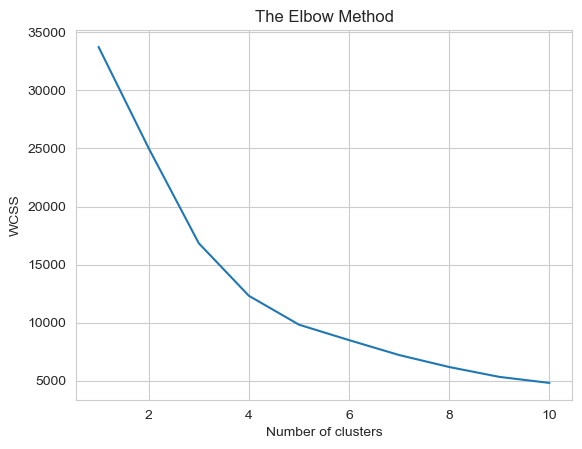

In [260]:
# standardization of values
X = score_dataframe[['Recency', 'Monetary Value', 'Frequency']]
sc_X = StandardScaler()
X_scd = sc_X.fit_transform(X)

# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_scd)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

From the graph above we deduced that the optimal **number of clusters** is either **4** or **5**, that's why we tried both numbers and picked the one with the best outcome.

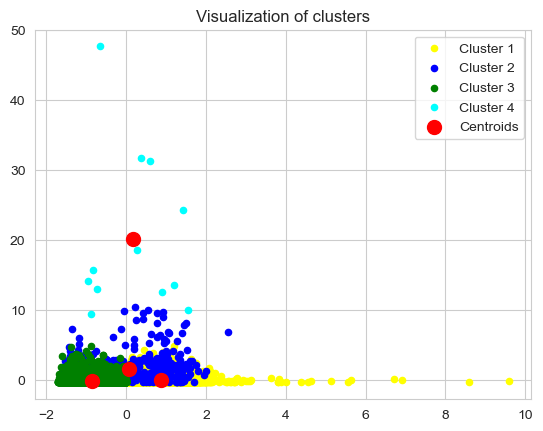

In [261]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X_scd)

# Visualising the clusters
plt.scatter(X_scd[y_kmeans == 0, 0], X_scd[y_kmeans == 0, 1], s = 20, c = 'yellow', label = 'Cluster 1')
plt.scatter(X_scd[y_kmeans == 1, 0], X_scd[y_kmeans == 1, 1], s = 20, c = 'blue', label = 'Cluster 2')
plt.scatter(X_scd[y_kmeans == 2, 0], X_scd[y_kmeans == 2, 1], s = 20, c = 'green', label = 'Cluster 3')
plt.scatter(X_scd[y_kmeans == 3, 0], X_scd[y_kmeans == 3, 1], s = 20, c = 'cyan', label = 'Cluster 4')
#plt.scatter(X_scd[y_kmeans == 4, 0], X_scd[y_kmeans == 4, 1], s = 30, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'red', label = 'Centroids')
plt.title('Visualization of clusters')
plt.legend()
plt.show()

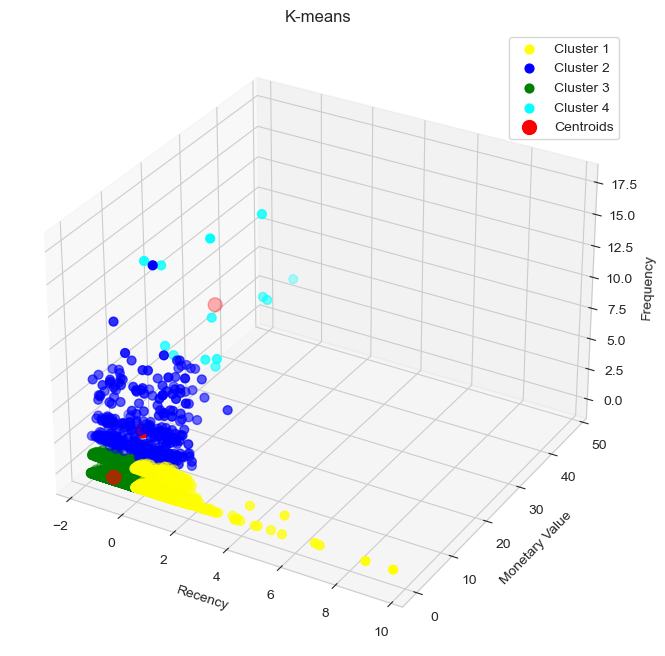

In [262]:
#plotting the clusters with the 3d visualization
fig= plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_scd[y_kmeans == 0,0],X_scd[y_kmeans == 0,1],X_scd[y_kmeans == 0,2], s = 40 , color = 'yellow', label = "Cluster 1")
ax.scatter(X_scd[y_kmeans == 1,0],X_scd[y_kmeans == 1,1],X_scd[y_kmeans == 1,2], s = 40 , color = 'blue', label = "Cluster 2")
ax.scatter(X_scd[y_kmeans == 2,0],X_scd[y_kmeans == 2,1],X_scd[y_kmeans == 2,2], s = 40 , color = 'green', label = "Cluster 3")
ax.scatter(X_scd[y_kmeans == 3,0],X_scd[y_kmeans == 3,1],X_scd[y_kmeans == 3,2], s = 40 , color = 'cyan', label = "Cluster 4")
#ax.scatter(X_scd[y_kmeans == 4,0],X_scd[y_kmeans == 4,1],X_scd[y_kmeans == 4,2], s = 40 , color = 'purple', label = "Cluster 5")
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],kmeans.cluster_centers_[:, 2], s = 100, c = 'red', label = 'Centroids')
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary Value')
ax.set_zlabel('Frequency')
ax.legend()
plt.title('K-means')
plt.show()

From the scatter plots we can visualize the **4 clusters** that we obtained, notice that we also ran the algorithm with k value equal to 5, but the outcome wasn't suitable.
Analyzing the 2D plot we realized it was difficult to make considerations on, due to the fact that it does not take in consideration the frequency variable. To solve this problem we plotted a 3D graph, that allows us to interpret the clusters based on the RFM values.
The **first (yellow)** cluster represents probably inactive customers that have made a few purchases a long time ago.
The **second one (blue)** contains active customers (low recency) that have made purchases many times.
The **third (green)** cluster contains new customers that in fact have not spent much, have a low frequency but have made purchases recently.
Finally, the **fourth (cyan)** cluster is quite similar to the blue one, besides the fact that their monetary value is relatively higher. This implies that they are probably very active regular customers.


At the end of each clustering we compute some metrics about their performance, will use them later on to compare the algorithms and pick the best one.

In [263]:
score_kmeans_s = silhouette_score(X_scd, kmeans.labels_, metric='euclidean')
score_kmeans_c = calinski_harabasz_score(X_scd, kmeans.labels_)
score_kmeans_d = davies_bouldin_score(X_scd, y_kmeans)

#### Hierarchical clustering
Hierarchical clustering groups data based on their  similarities, as we have done before we need to compute the optimal number of clusters, here though we use the **dendrogram** to find it, which shows the hierarchical relationship between clusters.

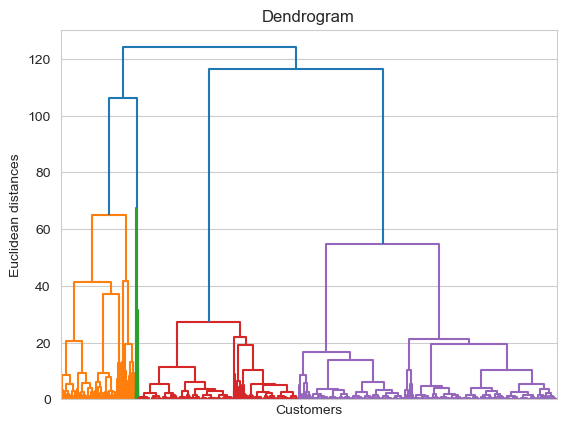

In [264]:
# Using the dendrogram to find the optimal number of clusters
dendrogram = sch.dendrogram(sch.linkage(X_scd, method = 'ward'))
# Ward's method: distance between two clusters A and B is how much the sum of squares will increase when we merge them
# single for min distance
# complete for max distance
# average for centroid distance
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.xticks([])    #no ticks are displayed
plt.show()

To determine the optimal number of graphs, we spot the largest vertical difference between nodes, then we cut it in half with a horizontal line. The number of vertical lines intersecting the horizontal line is the optimal number of clusters.
We obtained four so we passed it as a hyperparameter to the algorithm.

In [265]:
# Fitting Hierarchical Clustering to the dataset
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X_scd)

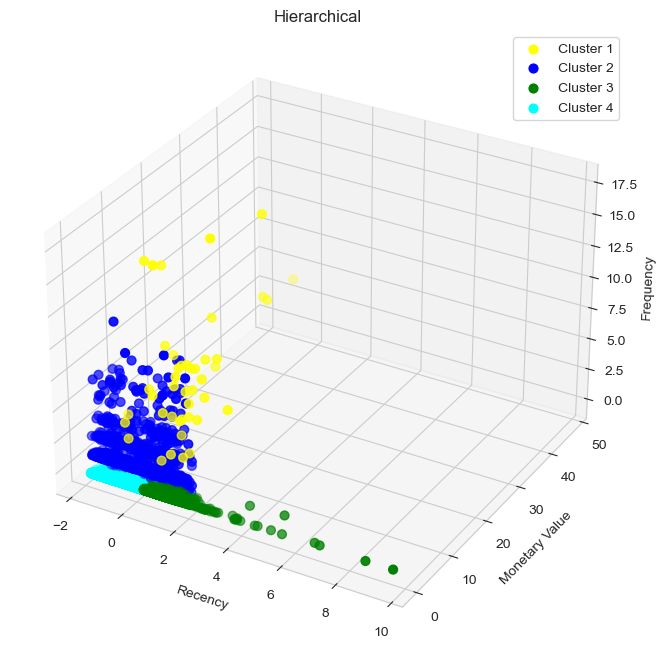

In [266]:
#plotting the clusters with the 3d visualization
fig= plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_scd[y_hc == 0,0],X_scd[y_hc == 0,1],X_scd[y_hc == 0,2], s = 40 , color = 'yellow', label = "Cluster 1")
ax.scatter(X_scd[y_hc == 1,0],X_scd[y_hc == 1,1],X_scd[y_hc == 1,2], s = 40 , color = 'blue', label = "Cluster 2")
ax.scatter(X_scd[y_hc == 2,0],X_scd[y_hc == 2,1],X_scd[y_hc == 2,2], s = 40 , color = 'green', label = "Cluster 3")
ax.scatter(X_scd[y_hc == 3,0],X_scd[y_hc == 3,1],X_scd[y_hc == 3,2], s = 40 , color = 'cyan', label = "Cluster 4")
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary Value')
ax.set_zlabel('Frequency')
ax.legend()
plt.title('Hierarchical')
plt.show()

From the plot we notice that the clusters obtained are very similar to the ones we obtained with the previous clustering, maybe we can notice that in the cluster three and four the customers order with a slight higher frequency than the clusters we had before (three and four).

In [267]:
score_hc_s = silhouette_score(X_scd, hc.labels_, metric='euclidean')
score_hc_c = calinski_harabasz_score(X_scd, hc.labels_)
score_hc_d = davies_bouldin_score(X_scd, y_hc)

#### Gaussian mixture model
The Gaussian Mixture Model assumes all data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. This algorithm works by assigning each data point to a mixture component based on the likelihood of it belonging to that component therefore Model it to group the data points belonging to a single distribution together.


In [268]:
#Gaussian mixture model
gmm= GaussianMixture(n_components=4)
gmm.fit(X_scd)  # fit the model
y_gmm = gmm.fit_predict(X_scd)  # assign a cluster to each example
clusters = unique(y_gmm)    # retrieve unique clusters
for cluster in clusters:    # create scatter plot for samples from each cluster
 row_ix = where(y_gmm == cluster)   # get row indexes for samples with this cluster

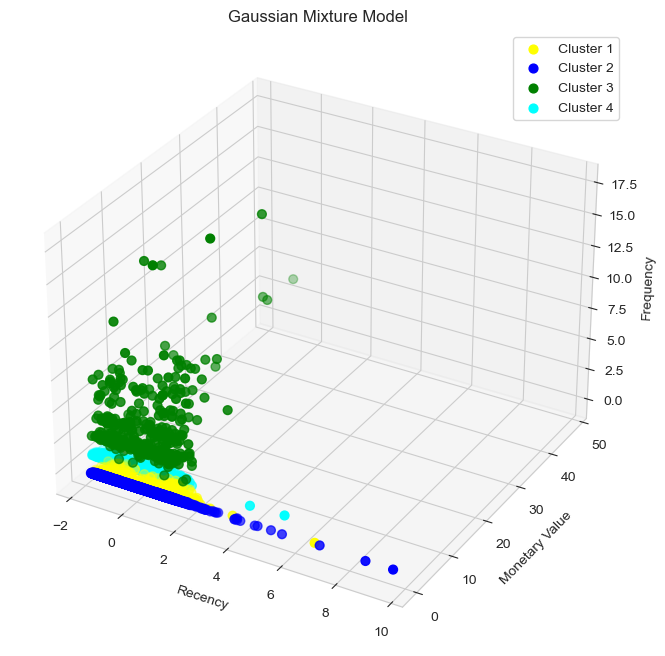

In [269]:
fig= plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_scd[y_gmm == 0,0],X_scd[y_gmm == 0,1],X_scd[y_gmm == 0,2], s = 40 , color = 'yellow', label = "Cluster 1")
ax.scatter(X_scd[y_gmm == 1,0],X_scd[y_gmm == 1,1],X_scd[y_gmm == 1,2], s = 40 , color = 'blue', label = "Cluster 2")
ax.scatter(X_scd[y_gmm == 2,0],X_scd[y_gmm == 2,1],X_scd[y_gmm == 2,2], s = 40 , color = 'green', label = "Cluster 3")
ax.scatter(X_scd[y_gmm == 3,0],X_scd[y_gmm == 3,1],X_scd[y_gmm == 3,2], s = 40 , color = 'cyan', label = "Cluster 4")
#ax.scatter(X_scd[y_gmm == 4,0],X_scd[y_gmm == 4,1],X_scd[y_gmm == 4,2], s = 40 , color = 'purple', label = "Cluster 5")
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary Value')
ax.set_zlabel('Frequency')
ax.legend()
plt.title('Gaussian Mixture Model')
plt.show()

This method creates slightly different clusters, looking at the 3D graph we can analyze them in depth:
The **first cluster (yellow)** is very similar to the **last one (cyan)**, making us think the clustering isn't that efficient, and they contain new customers that have made a few purchases and therefore haven't spent that much, moreover they have shopped recently.
The **second one (blue)** contains inactive customers that have made a few purchases a long time ago.
The **third one (green)** probably contains regular-high spender customers, that have in fact shopped very frequently and recently but have for some reasons spent not that much on their orders.


In [270]:
score_gmm_s = silhouette_score(X_scd, y_gmm, metric='euclidean')
score_gmm_c = calinski_harabasz_score(X_scd, y_gmm)
score_gmm_d = davies_bouldin_score(X_scd, y_gmm)

#### Birch model
Birch (Balanced Iterative Reducing and Clustering using Hierarchies) is a clustering algorithm used to cluster data points into a fixed number of clusters. It involves constructing a tree structure from which identify clusters  assigns each data point to the most relevant cluster, is very useful because it is an efficient algorithm that reduces the computational cost .

In [271]:
# birch clustering
birch = Birch(n_clusters=4)
birch.fit(X_scd)    # fit the model
y_birch = birch.predict(X_scd)  # assign a cluster to each example
clusters = unique(y_birch)  # retrieve unique clusters

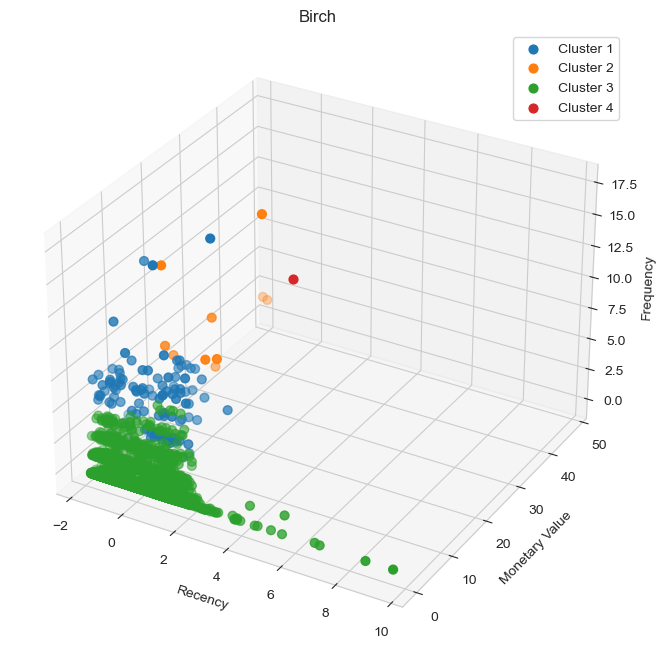

In [272]:
fig= plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_scd[y_birch == 0,0],X_scd[y_birch == 0,1],X_scd[y_birch == 0,2], s = 40, label = "Cluster 1")
ax.scatter(X_scd[y_birch == 1,0],X_scd[y_birch == 1,1],X_scd[y_birch == 1,2], s = 40, label = "Cluster 2")
ax.scatter(X_scd[y_birch == 2,0],X_scd[y_birch == 2,1],X_scd[y_birch == 2,2], s = 40, label = "Cluster 3")
ax.scatter(X_scd[y_birch == 3,0],X_scd[y_birch == 3,1],X_scd[y_birch == 3,2], s = 40, label = "Cluster 4")
#ax.scatter(X_scd[y_birch == 4,0],X_scd[y_birch == 4,1],X_scd[y_birch == 4,2], s = 40, label = "Cluster 5")

ax.legend()
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary Value')
ax.set_zlabel('Frequency')
plt.title('Birch')
plt.show()

As the plot shows the clusters are really different to each others.
The first cluster contains customers with low recency, high frequency and medium monetary values.
The second one contains only a few customers with medium recency, high frequency and high monetary value.
The third one is really consistent and represents a large variety of customers, many with both low and high recency, a relatively low frequency and a low monetary value.
The fourth cluster is very small, (we check later its size) and it represents customers with a low recency, high frequency and high monetary value.


In [273]:
score_birch_s = silhouette_score(X_scd, birch.labels_, metric='euclidean')
score_birch_c = calinski_harabasz_score(X_scd, birch.labels_)
score_birch_d = davies_bouldin_score(X_scd, y_birch)

To evaluate the methods and pick the best segmentation we computed some metrics that indicate the accuracy of the clustering.
We also stored them in a dataframe that makes it easier to plot them.

#### Methods evaluation

In [274]:
#comparing the 3 clustering algorithms based on the metrics
metrics={'Algorithm':['Kmeans', 'Hierarchical', 'GMM', 'Birch'],'Silhouette':[score_kmeans_s,score_hc_s, score_gmm_s, score_birch_s], 'Calinski Harabasz': [score_kmeans_c,score_hc_c, score_gmm_c, score_birch_c],'Davies Bouldin': [score_kmeans_d,score_hc_d, score_gmm_d, score_birch_d]}
metrics_df=pd.DataFrame(metrics)
metrics_df

,Algorithm,Silhouette,Calinski Harabasz,Davies Bouldin
0,Kmeans,0.491855,6521.885623,0.721628
1,Hierarchical,0.485409,5533.921146,0.871102
2,GMM,0.249033,2076.153162,1.734844
3,Birch,0.786022,2161.393252,0.561502


To clearly compare the clustering methods we plotted the different scores.
Firstly we tried to plot a unique graph that includes all the scores for each algorithm performed, but the difference in the range of numbers made it impossible to do it in a normal-sized graph, so we had to separate each score in different plots.

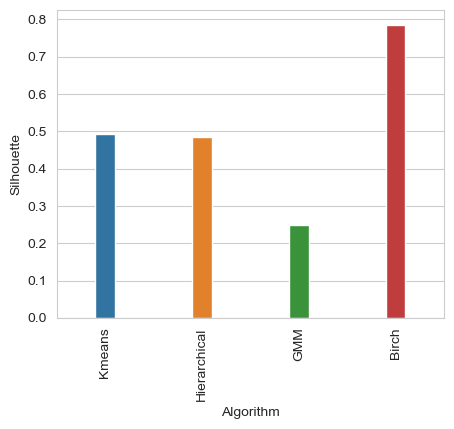

In [275]:
plt.figure(figsize=(5,4))
sns.barplot(x='Algorithm', y='Silhouette', data=metrics_df,width=0.2)
plt.xticks(rotation=90)
plt.show()

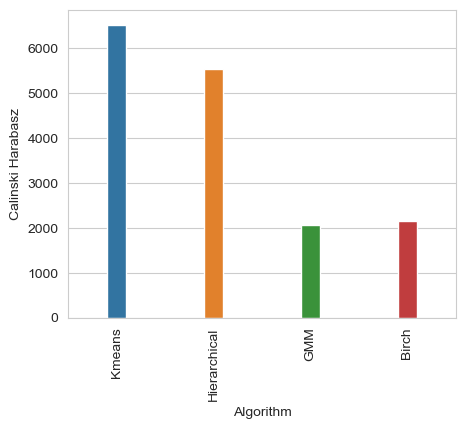

In [276]:
plt.figure(figsize=(5,4))
sns.barplot(x='Algorithm', y='Calinski Harabasz', data=metrics_df,width=0.2)
plt.xticks(rotation=90)
plt.show()

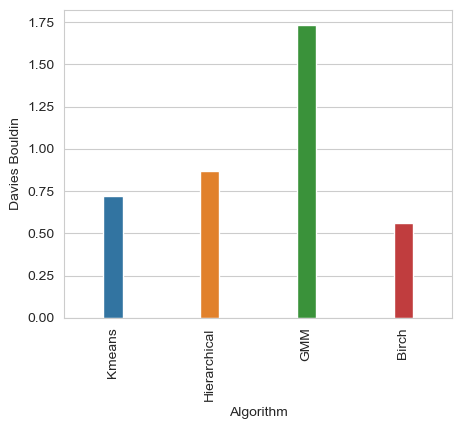

In [277]:
plt.figure(figsize=(5,4))
sns.barplot(x='Algorithm', y='Davies Bouldin', data=metrics_df,width=0.2)
plt.xticks(rotation=90)
plt.show()

Looking at the outcome the best model seems to be the Birch since it has the highest Silhouette score (it ranges between 1 and -1, and 1 indicates perfect clustering), althogh it has a low  Calinski Harabasz and medium  Davies Bouldin score.
 Also looking at the plot we realized the clusters are not well composed.
 After some considerations we conclude saying that the **best model** is clearly **Kmeans clustering**, as a matter of fact it has a high silhouette score, the highest Calinski Harabasz (the higher the score , the better the performances), and the lowest Davies Bouldin (The minimum score is zero, lower values indicate better clustering).
We also confirmed, as we deduced before, that the Gaussian mixture model isn't a suitable for our data, that's probably because we have a big dataset with well-defined data, and low noise, so the kmeans method works better  even if it's simpler.
Moreover, The GMM method is less sensitive to outliers.

Above we deduced the characteristics of each cluster just looking at the 3D plots, here we compute some measures to improve our deductions with empirical evidence.
We firstly calculate the size of each cluster obtained, and then we compute some information about the recency ,frequency and monetary value of the customers (that's why the outcome is three different dataframes) of each cluster, that help us generalize their characteristics.
We did the computations for each clustering method used.

##### Kmeans

In [278]:
#description of clusters created with Kmeans

data = X.assign(ClusterLabel = kmeans.labels_)
x_r=data.groupby("ClusterLabel")[["Recency"]].describe()
x_r.columns=['size of clusters','mean', 'std','min', '25%','median','75%','max']
x_f=data.groupby("ClusterLabel")[["Frequency"]].describe()
x_f.columns=['size of clusters','mean', 'std','min', '25%','median','75%','max']
x_m=data.groupby("ClusterLabel")[["Monetary Value"]].describe()
x_m.columns=['size of clusters','mean', 'std','min', '25%','median','75%','max']
display(x_r)
display(x_f)
display(x_m)

,size of clusters,mean,std,min,25%,median,75%,max
ClusterLabel,,,,,,,,
0,5368.0,110.233979,23.684231,73.0,92.0,111.0,125.0,482.0
1,399.0,75.739348,40.852009,2.0,37.0,79.0,111.0,182.0
2,5467.0,36.728004,19.728724,0.0,21.0,35.0,55.0,73.0
3,13.0,80.923077,39.277775,32.0,42.0,85.0,111.0,139.0


,size of clusters,mean,std,min,25%,median,75%,max
ClusterLabel,,,,,,,,
0,5368.0,1.127049,0.333059,1.0,1.0,1.0,1.0,2.0
1,399.0,3.729323,1.282631,1.0,3.0,3.0,4.0,12.0
2,5467.0,1.112859,0.316449,1.0,1.0,1.0,1.0,2.0
3,13.0,7.384615,3.042435,4.0,6.0,6.0,10.0,13.0


,size of clusters,mean,std,min,25%,median,75%,max
ClusterLabel,,,,,,,,
0,5368.0,194.226202,248.191509,14.38,68.3175,120.29,207.2775,3209.72
1,399.0,1214.238471,1222.835892,12.91,434.2400,822.33,1557.3350,6512.28
2,5467.0,180.876512,238.835959,10.71,63.3200,112.99,194.3300,3184.34
3,13.0,12448.780769,6681.136316,5948.36,8108.6400,9751.00,14963.6400,29099.52


##### Hierarchical clustering

In [279]:
#description of clusters created with Hierarchical clusters
data2 = X.assign(ClusterLabel = hc.labels_)
x_r2=data2.groupby("ClusterLabel")[["Recency"]].describe()
x_r2.columns=['size of clusters','mean', 'std','min', '25%','median','75%','max']
x_f2=data2.groupby("ClusterLabel")[["Frequency"]].describe()
x_f2.columns=['size of clusters','mean', 'std','min', '25%','median','75%','max']
x_m2=data2.groupby("ClusterLabel")[["Monetary Value"]].describe()
x_m2.columns=['size of clusters','mean', 'std','min', '25%','median','75%','max']
display(x_r2)
display(x_f2)
display(x_m2)

,size of clusters,mean,std,min,25%,median,75%,max
ClusterLabel,,,,,,,,
0,43.0,91.162791,37.003172,15.0,71.5,96.0,115.0,182.0
1,1712.0,74.835864,41.015206,1.0,36.0,77.0,111.0,165.0
2,3647.0,118.509186,20.955334,86.0,106.0,117.0,128.0,482.0
3,5845.0,44.406843,24.717987,0.0,23.0,41.0,66.0,105.0


,size of clusters,mean,std,min,25%,median,75%,max
ClusterLabel,,,,,,,,
0,43.0,5.348837,2.733250,1.0,4.0,5.0,6.0,13.0
1,1712.0,2.332944,0.903342,1.0,2.0,2.0,2.0,9.0
2,3647.0,1.000548,0.023415,1.0,1.0,1.0,1.0,2.0
3,5845.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


,size of clusters,mean,std,min,25%,median,75%,max
ClusterLabel,,,,,,,,
0,43.0,6991.476047,5171.210202,2928.24,4070.1600,5398.75,7180.68,29099.52
1,1712.0,524.567190,551.456450,10.71,184.5725,338.31,634.24,4080.58
2,3647.0,154.479021,166.894452,14.38,64.2250,107.62,173.59,1415.66
3,5845.0,156.663122,189.109654,13.89,60.3800,104.83,173.96,1930.34


##### Gaussian mixture method

In [280]:
#description of clusters created with Gaussian mixture method
data3 = X.assign(ClusterLabel =y_gmm)
x_r3=data3.groupby("ClusterLabel")[["Recency"]].describe()
x_r3.columns=['size of clusters','mean', 'std','min', '25%','median','75%','max']
x_f3=data3.groupby("ClusterLabel")[["Frequency"]].describe()
x_f3.columns=['size of clusters','mean', 'std','min', '25%','median','75%','max']
x_m3=data3.groupby("ClusterLabel")[["Monetary Value"]].describe()
x_m3.columns=['size of clusters','mean', 'std','min', '25%','median','75%','max']
display(x_r3)
display(x_f3)
display(x_m3)

,size of clusters,mean,std,min,25%,median,75%,max
ClusterLabel,,,,,,,,
0,1000.0,77.099000,42.794048,1.0,38.0,79.0,113.0,359.0
1,8531.0,72.374868,42.827300,0.0,34.0,71.0,110.0,482.0
2,416.0,76.033654,40.905048,2.0,37.0,80.0,111.0,182.0
3,1300.0,75.108462,41.712529,1.0,37.0,76.0,111.0,313.0


,size of clusters,mean,std,min,25%,median,75%,max
ClusterLabel,,,,,,,,
0,1000.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,8531.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,416.0,3.814904,1.529428,1.0,3.0,3.0,4.0,13.0
3,1300.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0


,size of clusters,mean,std,min,25%,median,75%,max
ClusterLabel,,,,,,,,
0,1000.0,639.822670,432.309602,284.84,353.0375,490.89,757.9125,2713.36
1,8531.0,108.550305,61.799140,13.89,57.7750,95.66,148.6950,284.66
2,416.0,1586.424471,2565.021659,12.91,454.5975,882.61,1706.7600,29099.52
3,1300.0,347.658108,268.676126,10.71,157.4075,275.80,458.3100,1633.68


##### Birch model

In [281]:
#description of clusters created with Birch method
data4 = X.assign(ClusterLabel = birch.labels_)
x_r4=data4.groupby("ClusterLabel")[["Recency"]].describe()
x_r4.columns=['size of clusters','mean', 'std','min', '25%','median','75%','max']
x_f4=data4.groupby("ClusterLabel")[["Frequency"]].describe()
x_f4.columns=['size of clusters','mean', 'std','min', '25%','median','75%','max']
x_m4=data4.groupby("ClusterLabel")[["Monetary Value"]].describe()
x_m4.columns=['size of clusters','mean', 'std','min', '25%','median','75%','max']
display(x_r4)
display(x_f4)
display(x_m4)

,size of clusters,mean,std,min,25%,median,75%,max
ClusterLabel,,,,,,,,
0,117.0,84.752137,41.751503,5.0,47.00,96.0,115.0,182.0
1,10.0,83.300000,36.031005,32.0,51.25,87.0,108.0,134.0
2,11119.0,73.118626,42.653579,0.0,35.00,72.0,110.0,482.0
3,1.0,45.000000,NaN,45.0,45.00,45.0,45.0,45.0


,size of clusters,mean,std,min,25%,median,75%,max
ClusterLabel,,,,,,,,
0,117.0,5.256410,1.722838,1.0,4.0,5.0,6.00,13.0
1,10.0,6.800000,2.394438,4.0,6.0,6.0,6.75,12.0
2,11119.0,1.171958,0.462403,1.0,1.0,1.0,1.00,5.0
3,1.0,4.000000,NaN,4.0,4.0,4.0,4.00,4.0


,size of clusters,mean,std,min,25%,median,75%,max
ClusterLabel,,,,,,,,
0,117.0,2158.779658,1826.550508,48.65,794.850,1303.080,3467.400,6512.28
1,10.0,12046.905000,4433.926323,7849.08,8514.205,10609.725,14345.450,19457.04
2,11119.0,204.661179,282.050459,10.71,66.900,118.900,209.425,3209.72
3,1.0,29099.520000,NaN,29099.52,29099.520,29099.520,29099.520,29099.52


Analyzing the data we confirm that our deductions were pretty accurate, in particular focusing on the outcome of the best clustering algorithm: Kmeans method, we conclude saying that Customers of the Brazilian subsidiary can be divided into four segments:
The first one represents inactive customers that have made a few purchases typically a long time ago.
The second one represents active customers that have made purchases many times, also recently, and have spent a fair amount on their purchases.
The third cluster represents new customers that have purchased very recently (they have in fact the lowest recency value) and have not spent much, because they haven't made frequent transactions yet.
Finally, the fourth cluster represents regular-high spender customers, they shop really frequently and spend a large amount of money on their orders (they have the highest monetary value).